# <u> A/B - тестирование: рекомендательная система<u> 
    
## Методика тестирования:
Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары. Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 (тестовой) оказались пользователи с новой системой рекомендаций, в группе 0 (контрольной) пользователи со старой версией приложения, где нет рекомендации товаров.

## Исходные данные:
    
1. **ab_users_data** - таблица c информацией о заказах:

    `user_id` - позаказный идентификатор пользователя; <br/>
    `order_id` - уникальный идентификатор заказа (номер чека);<br/>
    `action` - действие пользователя: create_order или cancel_order;<br/>
    `time` - время совершения действия;<br/> 
    `date` - дата совершения действия;<br/> 
    `group` - принадлежность пользователя к группе при АБ-тесте.<br/>


2. **ab_orders** - таблица с информацией о составе заказов:

    `order_id` - уникальный идентификатор заказа (номер чека);<br/>
    `creation_time` - время создания заказа;<br/> 
    `product_ids` - состав каждого заказа (в виде списка id товаров).<br/> 
    

3. **ab_products** - таблица с информацией товарных позициях:

    `product_id` - уникальный идентификатор товара;<br/>
    `name` - название товара;<br/> 
    `price` - цена товара.<br/> 
    
## Задача исследования:
Сделать аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

In [2]:
# Импорт библиотек

import pandas as pd
import numpy as np

from statsmodels.api import qqplot
import scipy.stats as st
import pingouin as pg

import requests
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Общие графические параметры

setting = sns.set(
    font_scale=1.4,
    style="white",
    rc={'figure.figsize':(15,7)}
        )

In [4]:
# URL-адреса исходных датасетов (для загрузки по API)

pb_keys = {
           'ab_users_data': 'https://disk.yandex.ru/d/4qY27tJ23G_B1g',
           'ab_orders':     'https://disk.yandex.ru/d/prdO8FDQx7lzCg', 
           'ab_products':   'https://disk.yandex.ru/d/atwrlmB_wu-fHA'
          }

In [5]:
# Функция загрузки csv-файла по API

def load_datasets(public_url: str) -> pd.DataFrame():

    base_url  = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_url))
    response  = requests.get(final_url) 
    download_url = response.json()['href']

    return pd.read_csv(download_url)

In [6]:
# Статистический вывод

def statistic_result(p_value: float) -> print:
    alpha = 0.05 # уровень значимости 
    if p_value < alpha:
        print("\nОтклоняем нулевую гипотезу H0")
    else:
        print("\nНе отклоняем нулевую гипотезу H0")

## EDA-анализ

Получение основной информации о датафреймах и изучение особенностей данных в них.

### 1. История заказов пользователей (ab_users_data)

In [7]:
ab_users_data = load_datasets(pb_keys['ab_users_data'])
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [8]:
# Переименуем группы

ab_users_data['group'] = np.where(ab_users_data.group == 1, 'test', 'control')
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,test
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,control
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,control
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,test


In [9]:
# Размер df

ab_users_data.shape

(4337, 6)

In [10]:
# Пропущенные значения не обнаружены

ab_users_data.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [11]:
# Число уникальных пользователей и категорий

ab_users_data.nunique()

user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64

In [12]:
# Полные дубликаты в данных отсутсвуют 

ab_users_data.duplicated().sum()

0

In [13]:
# Неуникальные заказы = отмененные заказы

ab_users_data[ab_users_data[['user_id', 'order_id']].duplicated()].head()

,user_id,order_id,action,time,date,group
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,control
39,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,control
47,995,1298,cancel_order,2022-08-26 00:49:51.514240,2022-08-26,control
54,1002,1308,cancel_order,2022-08-26 00:58:01.924112,2022-08-26,test
60,1008,1315,cancel_order,2022-08-26 01:06:11.292953,2022-08-26,control


**Примечание:** при подсчете метрик не будем учитывать отмененные заказы

In [14]:
# Отмененные заказы

canceled_orders = ab_users_data[ab_users_data[['user_id', 'order_id']].duplicated()].order_id

In [15]:
# Основаная информация о фрейме

ab_users_data.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   object
dtypes: int64(2), object(4)

### 2. Подробная информация о составе заказа (ab_orders)

In [16]:
ab_orders = load_datasets(pb_keys['ab_orders'])
ab_orders.head(10)

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
5,1261,2022-08-26 00:05:35.000000,"{30, 35, 69, 6}"
6,1262,2022-08-26 00:06:25.000000,"{23, 69, 45, 33}"
7,1263,2022-08-26 00:08:22.000000,"{22, 23, 5}"
8,1264,2022-08-26 00:10:53.000000,"{60, 5, 33, 69}"
9,1265,2022-08-26 00:11:21.000000,"{19, 35, 74, 42, 25}"


In [17]:
# Размер df

ab_orders.shape

(4123, 3)

In [18]:
# Пропущенные значения не обнаружены

ab_orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [19]:
# Число уникальных пользователей и категорий

ab_orders.nunique()

order_id         4123
creation_time    4098
product_ids      3877
dtype: int64

In [20]:
# Полные дубликаты в данных отсутсвуют 

ab_orders.duplicated().sum()

0

In [21]:
ab_orders[ab_orders['creation_time'].duplicated()].head()

,order_id,creation_time,product_ids
48,1310,2022-08-26 00:53:03.000000,"{56, 31, 63}"
71,1340,2022-08-26 01:24:04.000000,"{42, 51, 76, 69, 74}"
164,1455,2022-08-26 05:10:26.000000,"{57, 20, 32}"
355,1678,2022-08-26 09:38:22.000000,"{15, 58, 74}"
382,1709,2022-08-26 10:04:06.000000,"{22, 62, 24, 16}"


In [22]:
# Неуникальные времена создания заказов = заказы созданные в одно время

ab_orders[ab_orders.creation_time == '2022-08-26 00:53:03.000000']

,order_id,creation_time,product_ids
47,1311,2022-08-26 00:53:03.000000,"{63, 32}"
48,1310,2022-08-26 00:53:03.000000,"{56, 31, 63}"


In [23]:
# Основаная информация о фрейме

ab_orders.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)

### 3. Подробная информация о продуктах (ab_products)

In [24]:
ab_products = load_datasets(pb_keys['ab_products'])
ab_products.head(10)

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
5,6,сухарики,25.0
6,7,кофе зерновой,350.8
7,8,сушки,30.4
8,9,чай черный листовой,83.5
9,10,семечки,12.0


In [25]:
# Размер df

ab_products.shape

(87, 3)

In [26]:
# Пропущенные значения не обнаружены

ab_products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

In [27]:
# Число уникальных пользователей и категорий

ab_products.nunique()

product_id    87
name          87
price         63
dtype: int64

In [28]:
# Полные дубликаты в данных отсутсвуют 

ab_products.duplicated().sum()

0

In [29]:
# Основная информация о фрейме

ab_products.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)

# <u> Анализ результатов A/B - тестирования<u>

## 1. Доля отмененных заказов
    
Предположим, что новая система рекомендаций положительно влияет на пользовательский опыт использования приложения. Для проверки этой гипотезы посмотрим на долю отмененных заказов в группах. Имеются две категориальные переменные → **воспользуемся критерием хи-квадрат**

- $H_0$: доли отмененных заказов в группах равны
- $H_1$: доли отмененных заказов в группах не равны

In [30]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,test
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,control
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,control
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,test


In [31]:
# Создадим таблицу сопряженности 

pd.crosstab(ab_users_data.group, ab_users_data.action)

action,cancel_order,create_order
group,,
control,82,1609
test,132,2514


In [32]:
# Хи-квадрат тест независимости переменных в таблице сопряженности (без поправки Йетса)

stat, p, dof, expected  = st.chi2_contingency(pd.crosstab(ab_users_data.group, ab_users_data.action), correction=False)

In [33]:
# Статистика и p-value (> 0.05)

print('Statistic:', round(stat, 3))
print('p-value:  ', round(p, 3))

Statistic: 0.043
p-value:   0.836


In [34]:
# Доля отмененных заказов

part_canceled = ab_users_data \
                    .groupby('group') \
                    .apply(lambda x: x[x.action == 'cancel_order'][['action']].count() / x.shape[0]) \
                    .rename(columns={'action': 'orders'}) \
                    .mul(100) \
                    .round(2) \
                    .reset_index()
part_canceled

,group,orders
0,control,4.85
1,test,4.99


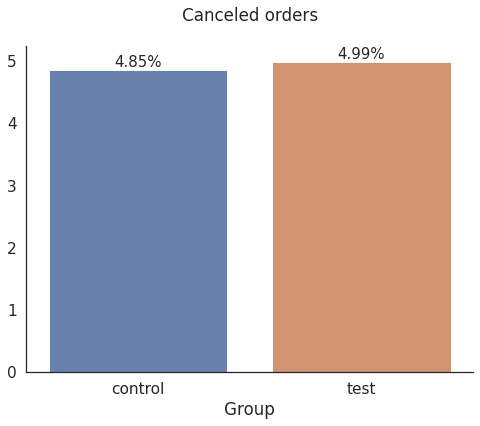

In [35]:
# Визуализация долей отмененных заказов в группах

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=part_canceled, x='group', y='orders', alpha=0.9)
ax.set(xlabel='Group', ylabel='')
ax.set_title('Canceled orders', pad=25)

for p in ax.patches:
    percentage = '{:.2f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=15)
sns.despine()
plt.show()

### Вывод №1:

Результаты теста не позволяют нам отклонить нулевую гипотезу (H0), следовательно, мы не можем утверждать, что новая система рекомендаций товаров приводит к изменению доли отмененных заказов.

## 2. Среднее количество заказов на пользователя

Предположим, что новая система рекомендаций товаров может стимулировать покупателей делать больше заказов т.к. она лучше чем старая понимает потребности и интересы конкретного пользователя.

In [36]:
df_count_orders = ab_users_data \
    .query("order_id not in @canceled_orders") \
    .groupby(['user_id', 'group'], as_index=False) \
    .agg({'order_id':'count'})
df_count_orders

,user_id,group,order_id
0,964,control,2
1,965,test,9
2,967,test,5
3,968,control,3
4,969,control,2
...,...,...,...
1008,1976,test,5
1009,1977,test,4
1010,1978,test,6
1011,1979,test,5


**Примечание:** при подсчете метрики не учитываются отмененные заказы

In [37]:
# Размер выборки тестовой и контрольной групп

df_count_orders.group.value_counts()

control    512
test       501
Name: group, dtype: int64

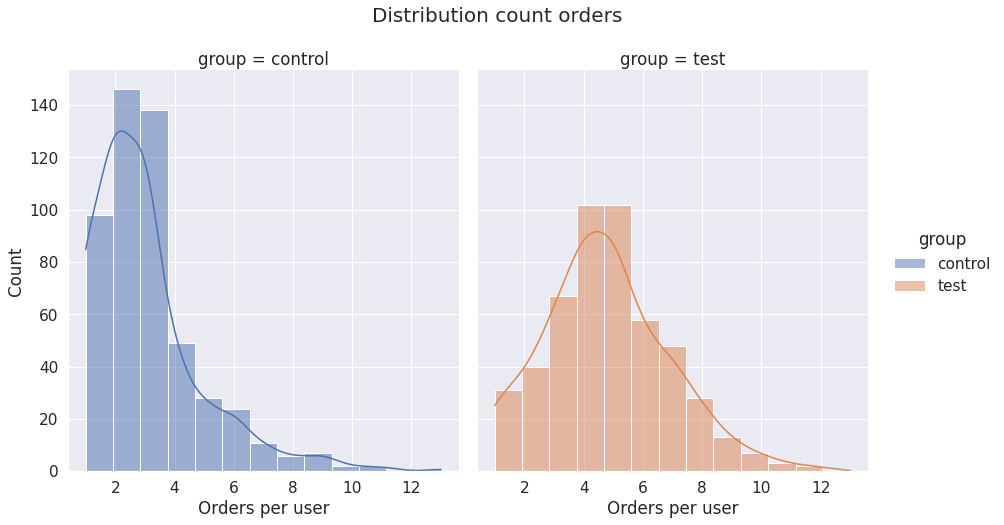

In [38]:
# Визуализация распределения количества заказов на пользователя

sns.set(font_scale=1.4, style="darkgrid")
ax = sns.displot(df_count_orders, height=7, aspect=0.9, x='order_id', hue='group', col='group', bins=13, kde=True)
ax.fig.suptitle('Distribution count orders', fontsize=20, y=1.05)
ax.set(xlabel='Orders per user')
plt.show()

### Проверим распределения на гомогенность дисперсий и нормальность

Для проверки гомогенности дисперсий используем тест Левена, так как он менее чувствителен к отклонениям от нормальности, чем тесты Фишера и Бартлетта. Для проверки нормальности используем тест Шапиро-Уилка.

In [39]:
# Проверка гомогенности дисперсий по критерию Левена

stat, p_val = st.levene(df_count_orders.query("group == 'control'").order_id, \
                        df_count_orders.query("group == 'test'").order_id)
print(f'В рассмотренных распределениях дисперсии гомогенны = {p_val > 0.05}')
print(f'pvalue = {round(p_val, 7)}')

В рассмотренных распределениях дисперсии гомогенны = False
pvalue = 3.65e-05


In [40]:
# Проверка нормальности распределения (тест Шапиро-Уилка)

stat_A, p_val_A = st.shapiro(df_count_orders.query("group == 'control'").order_id)
stat_B, p_val_B = st.shapiro(df_count_orders.query("group == 'test'").order_id)

print(f'Группа А (control): pvalue = {round(p_val_A, 25)}')
print(f'Группа B (test):    pvalue = {round(p_val_B, 12)}')

print(f'\nГруппа А (control): Распределение нормальное = {p_val_A > 0.05}')
print(f'Группа B (test):    Распределение нормальное = {p_val_B > 0.05}')

Группа А (control): pvalue = 4.71e-23
Группа B (test):    pvalue = 7.85e-10

Группа А (control): Распределение нормальное = False
Группа B (test):    Распределение нормальное = False


### Формулировка гипотез и выбор теста

Для применения T-test'a выделяют следующие два основных требования:

 - Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий).
 - Нормальность распределения данных обеих групп при применении t-теста. Во многих пособиях можно встретить довольно жесткое требование к нормальности данных по причине возможного завышения вероятности ошибки I рода. На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и если в данных нет заметных выбросов.
 
Для исследуемой метрики параметрические требования не выполняются: дисперсии не гомогенны и данные распределены ненормально, однако выборка довольна большая и отсутствуют выбросы, поэтому нормальностью распределения можно пренебречь, а различие в дисперсиях учесть при проведении тестирования → **используем T-test Уэлча**

- $H_0$: в генеральной совокупности никакого различия между средним количеством заказов на пользователя нет 
- $H_1$: в генеральной совокупности среднее количество заказов на пользователя различается

In [41]:
# T-test Уэлча (сравнение средних):

p_value = st.ttest_ind(df_count_orders.query("group == 'test'").order_id, \
                       df_count_orders.query("group == 'control'").order_id, \
                       equal_var=False).pvalue

print(f'pvalue = {round(p_value, 44)}')

statistic_result(p_value)

pvalue = 1.2374e-40

Отклоняем нулевую гипотезу H0


### Дополнительно
Для надежности вывода проведем сравнение доверительных интервалов для средних с помощью **Bootstrap** (необязательно):

In [42]:
# Бутстрап (тестовая группа)

ci = st.bootstrap((df_count_orders.query("group == 'test'").order_id, ), np.mean).confidence_interval

print(f'ConfidenceInterval: {[round(ci.low, 2), round(ci.high, 2)]}')

ConfidenceInterval: [4.57, 4.94]


In [43]:
# Бутстрап (контрольная группа)

ci = st.bootstrap((df_count_orders.query("group == 'control'").order_id, ), np.mean).confidence_interval

print(f'ConfidenceInterval: {[round(ci.low, 2), round(ci.high, 2)]}')

ConfidenceInterval: [2.83, 3.15]


### Вывод №2:

По результатам T-test'а отвергаем нулевую гипотезу и принимаем альтернативную (H1): **в генеральной совокупности среднее количество заказов на пользователя различается**. <br/> 

Данную альтернативную гипотезу также подтвердил проведенный bootstrap, где доверительные интервалы средних не пересекаются. По построенным гистограммам и проведенному статистическому тесту заключаем, что в тестовой группе (test) среднее количество заказов на пользователя статистически значимо больше, чем в контрольной группе (control).

## 3. Среднее число продуктов в заказе

Предположим, что новая система рекомендаций может привлечь внимание покупателей к большему числу товаров т.к. она работает более эффективно. Проверим это предположение статистическим тестом.

In [44]:
df_count_product = ab_users_data \
                    .query("order_id not in @canceled_orders") \
                    .merge(ab_orders, on='order_id') \
                    .reset_index(drop=True)
df_count_product

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,test,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,control,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,test,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
4,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,control,2022-08-26 00:05:35.000000,"{30, 35, 69, 6}"
...,...,...,...,...,...,...,...,...
3904,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,test,2022-09-08 23:13:03.000000,"{84, 8, 24}"
3905,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,test,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
3906,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,control,2022-09-08 23:22:27.000000,"{60, 41, 46}"
3907,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,control,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [45]:
# Подсчет количества товаров в заказах

df_count_product['count_products'] = df_count_product.product_ids.apply(lambda x: len(x.split(',')))
df_count_product

,user_id,order_id,action,time,date,group,creation_time,product_ids,count_products
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",4
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,test,2022-08-26 00:02:21.000000,"{56, 76, 39}",3
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,control,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}",4
3,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,test,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}",4
4,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,control,2022-08-26 00:05:35.000000,"{30, 35, 69, 6}",4
...,...,...,...,...,...,...,...,...,...
3904,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,test,2022-09-08 23:13:03.000000,"{84, 8, 24}",3
3905,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,test,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}",5
3906,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,control,2022-09-08 23:22:27.000000,"{60, 41, 46}",3
3907,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,control,2022-09-08 23:29:06.000000,"{9, 62, 77}",3


In [46]:
# Размер выборки тестовой и контрольной групп

df_count_product.group.value_counts()

test       2382
control    1527
Name: group, dtype: int64

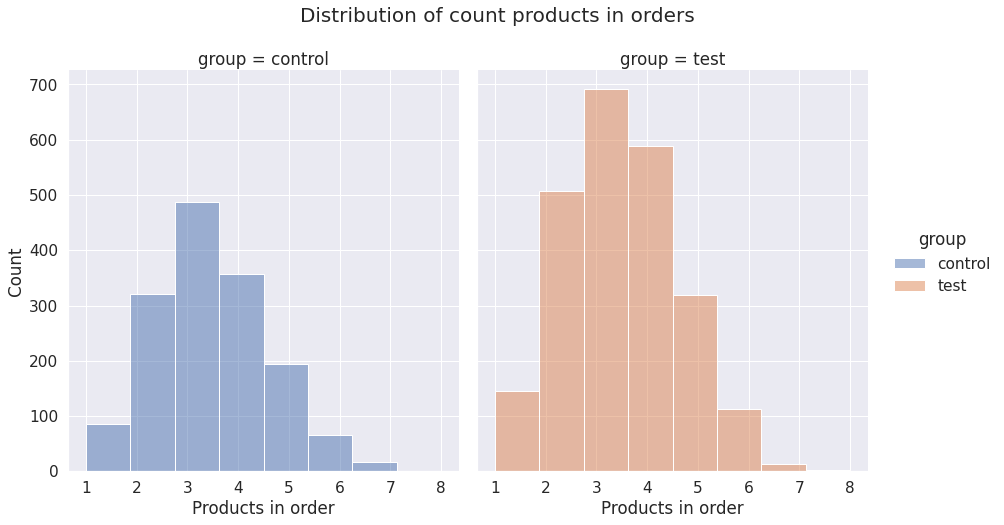

In [47]:
# Визуализация распределения количества заказов на пользователя

sns.set(font_scale=1.4, style="darkgrid")
ax = sns.displot(df_count_product, height=7, aspect=0.9, x='count_products', hue='group', col='group', bins=8, alpha=0.5)
ax.fig.suptitle('Distribution of count products in orders', fontsize=20, y=1.05)
ax.set(xlabel='Products in order')
plt.show()

### Проверим распределения на гомогенность дисперсий и нормальность

Для проверки гомогенности дисперсий используем тест Левена, так как он менее чувствителен к отклонениям от нормальности, чем тесты Фишера и Бартлетта. Для проверки нормальности используем тест Агостино-Пирсона, так как он имеет более высокую точность в сравнении с тестом Шапиро-Уилка на довольно больших выборках.

In [48]:
# Проверка гомогенности дисперсий по критерию Левена

stat, p_val = st.levene(df_count_product.query("group == 'control'").count_products, \
                        df_count_product.query("group == 'test'").count_products)
print(f'В рассмотренных распределениях дисперсии гомогенны = {p_val > 0.05}')
print(f'pvalue = {round(p_val, 3)}')

В рассмотренных распределениях дисперсии гомогенны = True
pvalue = 0.181


In [49]:
# Проверка нормальности распределения (тест Д'Агостино-Пирсона)

stat_A, p_val_A = st.normaltest(df_count_product.query("group == 'control'").count_products)
stat_B, p_val_B = st.normaltest(df_count_product.query("group == 'test'").count_products)

print(f'Группа А (control): pvalue = {round(p_val_A, 10)}')
print(f'Группа B (test):    pvalue = {round(p_val_B, 12)}')

print(f'\nГруппа А (control): Распределение нормальное = {p_val_A > 0.05}')
print(f'Группа B (test):    Распределение нормальное = {p_val_B > 0.05}')

Группа А (control): pvalue = 1.32e-08
Группа B (test):    pvalue = 6.85e-10

Группа А (control): Распределение нормальное = False
Группа B (test):    Распределение нормальное = False


### Формулировка гипотез и выбор теста

Для применения T-test'a выделяют следующие два основных требования:

 - Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий).
 - Нормальность распределения данных обеих групп при применении t-теста. Во многих пособиях можно встретить довольно жесткое требование к нормальности данных по причине возможного завышения вероятности ошибки I рода. На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и если в данных нет заметных выбросов.
 
Для исследуемой метрики параметрические требования не выполняются в полной мере: дисперсии гомогенны, но данные в группах распределены ненормально. Поскольку выборка довольна большая и отсутствуют выбросы нормальностью распределения можно пренебречь → **используем T-test Стьюдента**

- $H_0$: в генеральной совокупности никакого различия между средним количеством продуктов в заказе нет 
- $H_1$: в генеральной совокупности среднее количество продуктов в заказе различается

In [50]:
# T-test Стьюдента (сравнение средних):

p_value = st.ttest_ind(df_count_product.query("group == 'test'").count_products, \
                       df_count_product.query("group == 'control'").count_products).pvalue
print(f'pvalue = {round(p_value, 3)}')

statistic_result(p_value)

pvalue = 0.844

Не отклоняем нулевую гипотезу H0


### Вывод №3:

Результаты T-test'а не позволяют нам отклонить нулевую гипотезу (H0), следовательно, мы не можем утверждать, что новая система рекомендаций товаров приводит изменению количества продуктов в заказе. Предположение не подтвердилось.<br/> 

## 4. Средний доход с пользователя (ARPU)

Как уже известно, новая система рекомендаций привела к увеличению количества заказов у пользователей. Остается проверить привело ли это изменение к изменению дохода бизнеса. В случае, если доход увеличился, то можно предположить, что  средний чек заказов как минимум не изменился, а может даже и увеличился (что маловероятно, но система потенциально может рекомендовать товары лучшего качества по более высокой цене).

In [51]:
# Создадим список продуктов в каждом заказе

df_count_product['product_ids'] = df_count_product.product_ids.apply(lambda x: x.strip('{}').split(','))
df_count_product.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,count_products
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]",4
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,test,2022-08-26 00:02:21.000000,"[56, 76, 39]",3
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,control,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]",4
3,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,test,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]",4
4,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,control,2022-08-26 00:05:35.000000,"[30, 35, 69, 6]",4


In [52]:
# Распакуем этот список и создадим датафрейм с информацией о товарах в заказах

df_products_info = df_count_product.explode('product_ids') \
                                   .drop(['count_products', 'creation_time'], axis=1) \
                                   .rename(columns={'product_ids':'product_id'})
df_products_info

,user_id,order_id,action,time,date,group,product_id
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control,75
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control,22
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control,53
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control,84
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,test,56
...,...,...,...,...,...,...,...
3907,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,control,9
3907,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,control,62
3907,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,control,77
3908,1376,59533,create_order,2022-09-08 23:41:24.000000,2022-09-08,control,17


In [53]:
df_products_info['product_id'] = df_products_info.product_id.astype('int64')

In [54]:
# Датафрейм с полной информацией о товарах в заказах

df_products_info = df_products_info.merge(ab_products, how='left', on='product_id')
df_products_info

,user_id,order_id,action,time,date,group,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,control,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,test,56,сосиски,150.0
...,...,...,...,...,...,...,...,...,...
13078,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,control,9,чай черный листовой,83.5
13079,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,control,62,сок яблочный,120.0
13080,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,control,77,курица,298.4
13081,1376,59533,create_order,2022-09-08 23:41:24.000000,2022-09-08,control,17,морс брусничный,190.0


In [55]:
# Рассчтаем доход с каждого пользователя

df_revenue = df_products_info \
    .groupby(['user_id','group'], as_index=False) \
    .agg({'price':'sum'}) \
    .round(2)
df_revenue

,user_id,group,price
0,964,control,718.9
1,965,test,4155.5
2,967,test,1137.4
3,968,control,1590.7
4,969,control,681.9
...,...,...,...
1008,1976,test,2001.9
1009,1977,test,781.2
1010,1978,test,2276.3
1011,1979,test,1907.1


In [56]:
# Размер выборки тестовой и контрольной групп

df_revenue.group.value_counts()

control    512
test       501
Name: group, dtype: int64

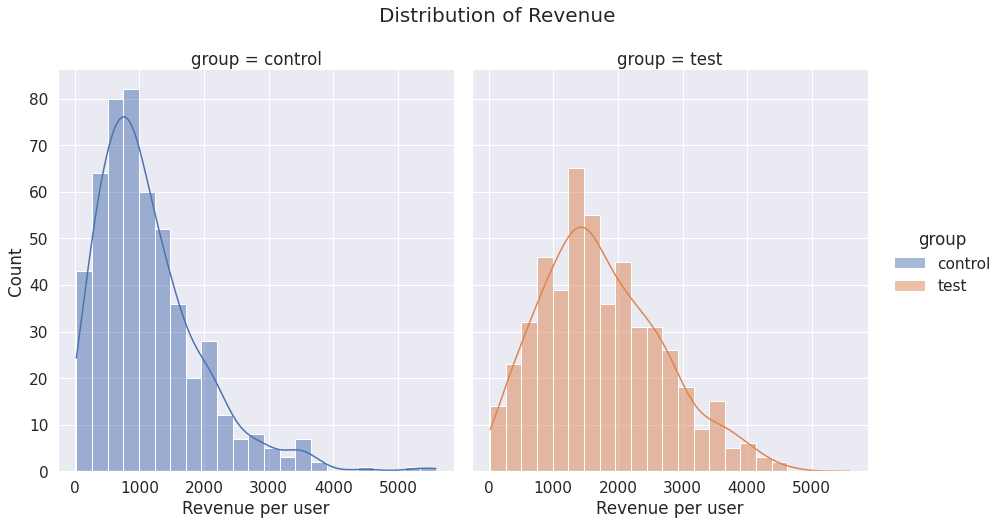

In [57]:
# Визуализация распределения дохода с пользователей

sns.set(font_scale=1.4, style="darkgrid")
ax = sns.displot(df_revenue, height=7, aspect=0.9, x='price', hue='group', col='group', kde=True)
ax.fig.suptitle('Distribution of Revenue', fontsize=20, y=1.05)
ax.set(xlabel='Revenue per user')
plt.show()

### Проверим распределения на гомогенность дисперсий и нормальность

Для проверки гомогенности дисперсий используем тест Левена, так как он менее чувствителен к отклонениям от нормальности, чем тесты Фишера и Бартлетта. Для проверки нормальности используем тест Шапиро-Уилка и Q-Q Plot графики.

In [58]:
# Проверка гомогенности дисперсий по критерию Левена

stat, p_val = st.levene(df_revenue.query("group == 'control'").price, \
                        df_revenue.query("group == 'test'").price)
print(f'В рассмотренных распределениях дисперсии гомогенны = {p_val > 0.05}')
print(f'pvalue = {round(p_val, 8)}')

В рассмотренных распределениях дисперсии гомогенны = False
pvalue = 1.896e-05


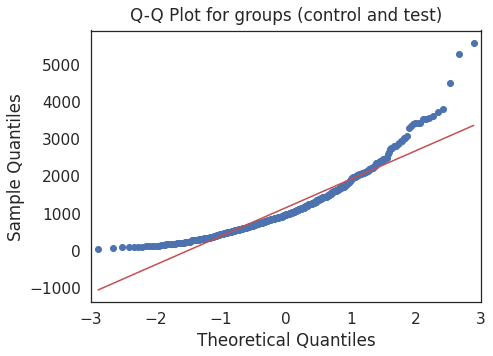

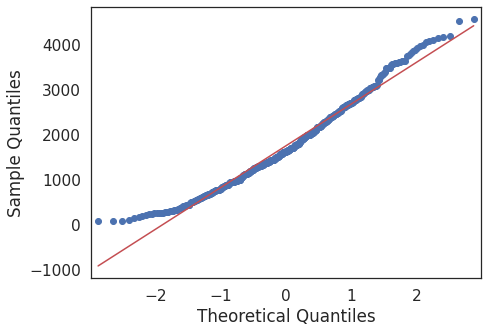

In [59]:
# Проверка нормальности c помощью qqplot 

sns.set(font_scale=1.4, style="white")

fig1 = plt.figure(figsize=(7, 5))
qqplot(df_revenue.query("group == 'control'").price, line="r", ax=fig1.add_subplot(111))
plt.title("Q-Q Plot for groups (control and test)", pad=10)

fig2 = plt.figure(figsize=(7, 5))
qqplot(df_revenue.query("group == 'test'").price, line="r", ax=fig2.add_subplot(111))
plt.show()
plt.close()

**Примечание:** полученные Q-Q plot графики демонстрируют, что данные в группах не следуют нормальному распределению, поскольку точки на графиках значительно отклоняются от линии соответствия (особенно в хвостах).

In [60]:
# Проверка нормальности распределения (тест Шапиро-Уилка)

stat_A, p_val_A = st.shapiro(df_revenue.query("group == 'control'").price)
stat_B, p_val_B = st.shapiro(df_revenue.query("group == 'test'").price)

print(f'Группа А (control): pvalue = {round(p_val_A, 21)}')
print(f'Группа B (test):    pvalue = {round(p_val_B, 9)}')

print(f'\nГруппа А (control): Распределение нормальное = {p_val_A > 0.05}')
print(f'Группа B (test):    Распределение нормальное = {p_val_B > 0.05}')

Группа А (control): pvalue = 8.71e-19
Группа B (test):    pvalue = 1.41e-07

Группа А (control): Распределение нормальное = False
Группа B (test):    Распределение нормальное = False


### Формулировка гипотез и выбор теста

Для применения T-test'a выделяют следующие два основных требования:

 - Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий).
 - Нормальность распределения данных обеих групп при применении t-теста. Во многих пособиях можно встретить довольно жесткое требование к нормальности данных по причине возможного завышения вероятности ошибки I рода. На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и если в данных нет заметных выбросов.

Для исследуемой метрики параметрические требования не выполняются: дисперсии не гомогенны и данные распределены ненормально, однако выборка довольна большая и отсутствуют выбросы, поэтому нормальностью распределения можно пренебречь, а различие в дисперсиях учесть при проведении тестирования → **используем T-test Уэлча**

- $H_0$: в генеральной совокупности никакого различия между средним доходом с пользователя нет 
- $H_1$: в генеральной совокупности средний доход с пользователя различается

In [61]:
# T-test Уэлча (сравнение средних):

p_value = st.ttest_ind(df_revenue.query("group == 'test'").price, \
                      df_revenue.query("group == 'control'").price, equal_var=False).pvalue
print(f'pvalue = {round(p_value, 29)}')

statistic_result(p_value)

pvalue = 1.57e-27

Отклоняем нулевую гипотезу H0


### Дополнительно

Для надежности вывода проведем сравнение доверительных интервалов для средних с помощью **Bootstrap** (необязательно):

In [62]:
# Бутстрап среднего (тестовая группа)

pg.compute_bootci(df_revenue.query("group == 'test'").price, func='mean')

array([1670.52, 1834.13])

In [63]:
# Бутстрап среднего (контрольная группа)

pg.compute_bootci(df_revenue.query("group == 'control'").price, func='mean')

array([1072.73, 1211.66])

In [64]:
# Общий доход бизнеса по группам за время тестирования

df_revenue.groupby('group').agg({'price':'sum'})

,price
group,
control,583455.9
test,878628.4


### Вывод №4:

По результатам T-test'а отвергаем нулевую гипотезу и принимаем альтернативную (H1): **в генеральной совокупности средний доход с пользователя различается**. <br/> 

Данную альтернативную гипотезу также подтвердил проведенный bootstrap, где доверительные интервалы средних не пересекаются. По построенным гистограммам и проведенному статистическому тесту заключаем, что в тестовой группе (1) доход с пользователя статистически значимо больше, чем в контрольной группе (0).<br/> 

К слову, общий доход с пользователей тестовой группы также оказался больше дохода с пользователей контрольной группы, что лишний раз подтверждает наши выводы.

## Заключение:

### По результатам анализа эффективности новой системы рекомендаций товаров не было выявлено значительных изменений в доле отмененных заказов и среднем количестве продуктов в заказах, однако новая система статистически значимо увеличивает средний доход бизнеса c пользователя и среднее количество заказов на пользователя.

### Следовательно, система считается эффективной и рекомендуется включать ее для всех пользователей приложения.